In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


100%|██████████| 21/21 [00:52<00:00,  2.50s/it]


Epoch [1/25], Loss: 14.8144, Accuracy: 50.91%


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


Epoch [2/25], Loss: 14.4673, Accuracy: 57.58%


100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Epoch [3/25], Loss: 14.6227, Accuracy: 53.33%


100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


Epoch [4/25], Loss: 14.3422, Accuracy: 55.76%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [5/25], Loss: 14.3900, Accuracy: 56.97%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [6/25], Loss: 14.3703, Accuracy: 55.15%


100%|██████████| 21/21 [00:12<00:00,  1.64it/s]


Epoch [7/25], Loss: 14.1607, Accuracy: 62.42%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [8/25], Loss: 14.0361, Accuracy: 59.39%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [9/25], Loss: 13.9182, Accuracy: 62.42%


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


Epoch [10/25], Loss: 13.9939, Accuracy: 56.97%


100%|██████████| 21/21 [00:10<00:00,  1.95it/s]


Epoch [11/25], Loss: 14.1797, Accuracy: 53.94%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [12/25], Loss: 13.3633, Accuracy: 75.15%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [13/25], Loss: 13.0247, Accuracy: 70.91%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [14/25], Loss: 12.4641, Accuracy: 73.94%


100%|██████████| 21/21 [00:11<00:00,  1.80it/s]


Epoch [15/25], Loss: 11.9959, Accuracy: 75.76%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [16/25], Loss: 11.5663, Accuracy: 73.33%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [17/25], Loss: 12.7931, Accuracy: 63.64%


100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


Epoch [18/25], Loss: 11.3552, Accuracy: 77.58%


100%|██████████| 21/21 [00:10<00:00,  1.91it/s]


Epoch [19/25], Loss: 10.6594, Accuracy: 80.00%


100%|██████████| 21/21 [00:11<00:00,  1.80it/s]


Epoch [20/25], Loss: 10.1385, Accuracy: 82.42%


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


Epoch [21/25], Loss: 10.1635, Accuracy: 80.00%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [22/25], Loss: 9.6695, Accuracy: 81.21%


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


Epoch [23/25], Loss: 9.1390, Accuracy: 81.82%


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


Epoch [24/25], Loss: 8.8430, Accuracy: 87.27%


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


Epoch [25/25], Loss: 8.6348, Accuracy: 83.64%
Model saved as 'mpcnn_classifier.pth'
mAP score (AP for class 'waste_absent'): 0.9537
mAP score (AP for class 'waste_present'): 0.9593


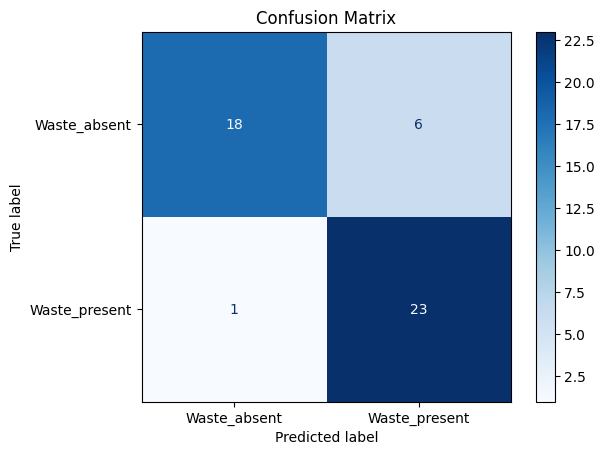

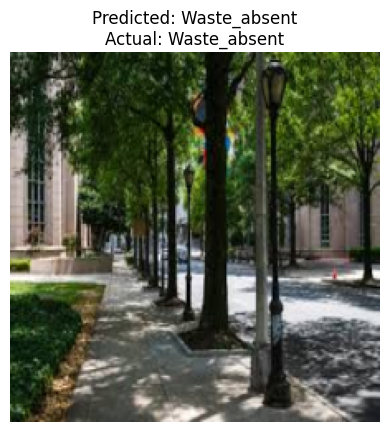

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# --- Multi-Path CNN Model ---
class MPCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(MPCNN, self).__init__()
        self.path1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.path2 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.path3 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=3), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x1 = self.global_pool(self.path1(x))
        x2 = self.global_pool(self.path2(x))
        x3 = self.global_pool(self.path3(x))
        x_concat = torch.cat((x1, x2, x3), dim=1)
        return self.classifier(x_concat)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="/content/drive/MyDrive/review two data", transform=transform)
class_names = dataset.classes  # ['waste_absent', 'waste_present']

# Split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# Model, Loss, Optimizer
model = MPCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save Model
torch.save(model.state_dict(), "mpcnn_classifier.pth")
print("Model saved as 'mpcnn_classifier.pth'")

# mAP Evaluation
model.eval()
all_labels, all_probs, all_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

ap_0 = average_precision_score(all_labels == 0, all_probs[:, 0])
ap_1 = average_precision_score(all_labels == 1, all_probs[:, 1])

print(f"mAP score (AP for class 'waste_absent'): {ap_0:.4f}")
print(f"mAP score (AP for class 'waste_present'): {ap_1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Sample Output
index = random.randint(0, len(test_set) - 1)
sample_image, sample_label = test_set[index]
image_tensor = sample_image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, pred_class = torch.max(output, 1)

img_np = sample_image.permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
plt.title(f"Predicted: {class_names[pred_class.item()]}\nActual: {class_names[sample_label]}")
plt.axis("off")
plt.show()


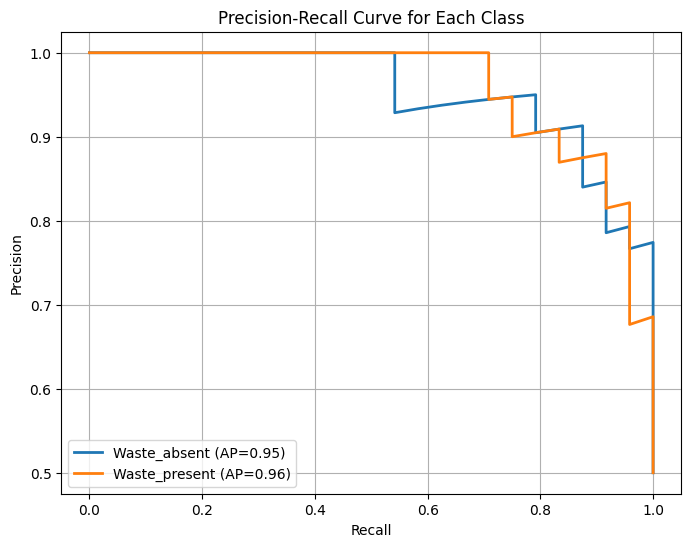

In [4]:
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(8, 6))

for i, class_name in enumerate(class_names):
    binary_labels = (all_labels == i).astype(int)
    precision, recall, _ = precision_recall_curve(binary_labels, all_probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f"{class_name} (AP={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.grid(True)
plt.show()


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [1/25] Train Loss: 0.4319 | Train Acc: 80.61% | Val Loss: 0.4413 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [2/25] Train Loss: 0.4043 | Train Acc: 84.24% | Val Loss: 0.4090 | Val Acc: 91.30%


100%|██████████| 21/21 [00:12<00:00,  1.66it/s]


Epoch [3/25] Train Loss: 0.3902 | Train Acc: 83.64% | Val Loss: 0.4092 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [4/25] Train Loss: 0.3932 | Train Acc: 82.42% | Val Loss: 0.4437 | Val Acc: 73.91%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [5/25] Train Loss: 0.3713 | Train Acc: 84.24% | Val Loss: 0.3769 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [6/25] Train Loss: 0.3801 | Train Acc: 85.45% | Val Loss: 0.5362 | Val Acc: 73.91%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [7/25] Train Loss: 0.3861 | Train Acc: 81.21% | Val Loss: 0.3853 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [8/25] Train Loss: 0.3550 | Train Acc: 87.27% | Val Loss: 0.3731 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [9/25] Train Loss: 0.3900 | Train Acc: 81.21% | Val Loss: 0.3822 | Val Acc: 86.96%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [10/25] Train Loss: 0.3490 | Train Acc: 85.45% | Val Loss: 0.3509 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [11/25] Train Loss: 0.3598 | Train Acc: 83.64% | Val Loss: 0.5395 | Val Acc: 78.26%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [12/25] Train Loss: 0.3956 | Train Acc: 82.42% | Val Loss: 0.4637 | Val Acc: 82.61%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [13/25] Train Loss: 0.3601 | Train Acc: 84.24% | Val Loss: 0.3817 | Val Acc: 95.65%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [14/25] Train Loss: 0.3561 | Train Acc: 84.85% | Val Loss: 0.3863 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [15/25] Train Loss: 0.3162 | Train Acc: 86.06% | Val Loss: 0.3528 | Val Acc: 86.96%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [16/25] Train Loss: 0.3364 | Train Acc: 84.85% | Val Loss: 0.4432 | Val Acc: 65.22%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [17/25] Train Loss: 0.3632 | Train Acc: 83.03% | Val Loss: 0.3939 | Val Acc: 82.61%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [18/25] Train Loss: 0.3490 | Train Acc: 84.24% | Val Loss: 0.4273 | Val Acc: 86.96%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [19/25] Train Loss: 0.3348 | Train Acc: 86.67% | Val Loss: 0.3790 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [20/25] Train Loss: 0.3273 | Train Acc: 87.88% | Val Loss: 0.3647 | Val Acc: 95.65%


100%|██████████| 21/21 [00:11<00:00,  1.82it/s]


Epoch [21/25] Train Loss: 0.3389 | Train Acc: 84.85% | Val Loss: 0.3301 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [22/25] Train Loss: 0.3327 | Train Acc: 86.67% | Val Loss: 0.5815 | Val Acc: 73.91%


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


Epoch [23/25] Train Loss: 0.3594 | Train Acc: 84.24% | Val Loss: 0.3799 | Val Acc: 91.30%


100%|██████████| 21/21 [00:11<00:00,  1.76it/s]


Epoch [24/25] Train Loss: 0.3970 | Train Acc: 84.85% | Val Loss: 0.3771 | Val Acc: 86.96%


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


Epoch [25/25] Train Loss: 0.3535 | Train Acc: 83.64% | Val Loss: 0.3508 | Val Acc: 86.96%


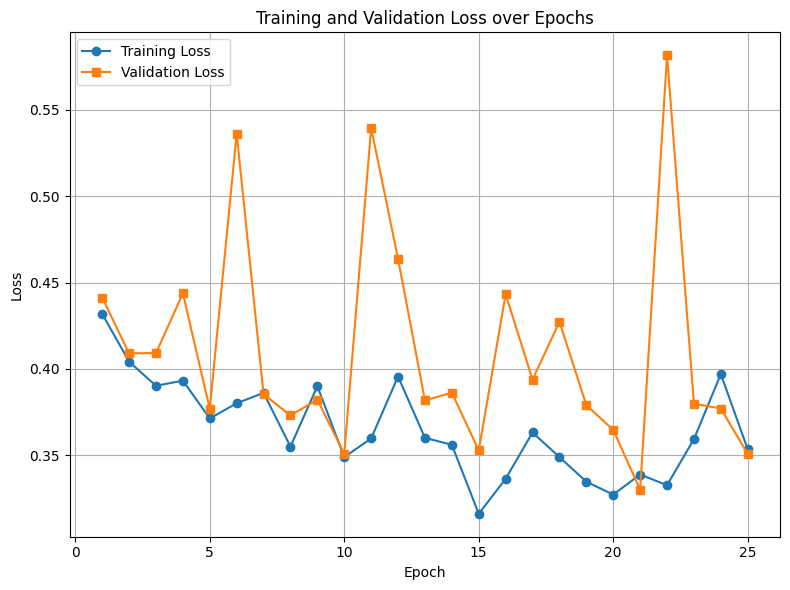

In [3]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
